# Simpler case: negligible noise

$$
\begin{align}
\text{MI}(Y;N) &= \sum_{n} p_N(n) \sum_{y} p_{Y|N}(y|n,\theta) \left( \log p_{Y|N}(y|n, \theta) - \log p_Y(y | \theta) \right) \\
&= - \sum_{n} p_N(n) \log p_Y(\hat y(n, \theta) | \theta) = - \sum_{n} p_N(n) \log \left( \sum_{k: \hat y(n, \theta) = \hat y(k, \theta)} p_N(k)\right) \\ 
&= - \sum_{s\in \Chi} p_S(s|\theta) \log p_S(s|\theta) \\
\text{ where } p_S(s|\theta) &= \sum_{k \in s} p_N(k) \\ 
\text{ and } \Chi =& \{\hat y^{-1}(y, \theta) : y \in \{0,2^B-1\}\}\\ 
\end{align}
$$

For evenly $K$ spaced bins with spacing $\alpha$ starting at $\beta$ plus one bin stretching to infinity in each direction, and enumerating these bins from left to right, we have $p_S(s_i) = \sum_{k \in s_i} p_N(k)$ where $s_0 = \{ -\infty, ..., \lfloor \beta \rfloor \}$, $s_i = \{ \lceil \beta + \alpha(i-1) \rceil, ..., \lfloor \beta + \alpha i \rfloor \}$ for $i = 1, ..., K$, and $s_{K+1} = \{ \lceil \beta + \alpha K \rceil, \infty \}$.

Hence the probabilities are $p_S(s_0) = F_N(\lfloor \beta \rfloor)$, $p_S(s_i) = F_N(\lfloor \beta + \alpha i \rfloor) - F_N(\lceil \beta + \alpha(i-1) \rceil)$ for $i = 1, ..., K$, and $p_S(s_{K+1}) = 1 - F_N(\lceil \beta + \alpha K \rceil)$.

In [1]:
import __init__
from functools import partial
import jax
from jax import numpy as jnp
from numpyro import distributions as dists
from matplotlib import pyplot as plt
from adim import *
from tqdm.auto import tqdm
plt.style.use('ggplot')
jax.config.update("jax_enable_x64", True)
# set linecolors to tab10
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
from scipy.optimize import curve_fit

from tqdm import tqdm
from matplotlib.ticker import FixedLocator, MaxNLocator
from matplotlib.ticker import MultipleLocator, FixedLocator


Adding '/Users/johannes/Projects/ISCAS 25/Optimal Thresholds for Approximate Analog In-Memory Computing' to path...


In [2]:
# phase offset can be -1, -0.5, or 0 (we started with centered bins)
phase = jnp.array([-1, -0.5, 0])
scale = 2**jnp.linspace(-5, 7, 9901)
# scale = 1.0/jnp.linspace(20, 1/128, 2001)

vector_length = (2**jnp.arange(1, 16.1, 0.125)).astype(jnp.int32)
enobs = []
rhos = [4, 6, 8]
# labels = ["low-res.", "mid-res.", "high-res."]
labels = [f"$\\rho = {rho}$" for rho in rhos]
cases = list(zip(labels, rhos))
max_MIs = [[] for _ in range(len(cases))]
num_bits = [[] for _ in range(len(cases))]
max_scales = [[] for _ in range(len(cases))]
max_phases = [[] for _ in range(len(cases))]
max_ranges = [[] for _ in range(len(cases))]
max_widths = [[] for _ in range(len(cases))]

for vl in tqdm(vector_length):
    # generate distribution for given vector length
    d = dists.Binomial(vl, 0.5)
    support = jnp.array(d.enumerate_support())*2 - vl
    probabilities = jnp.exp(d.log_prob(d.enumerate_support()))

    # compute ENOB
    ENOB = enob(vl)
    enobs.append(ENOB)

    for i,(label,bits) in enumerate(cases):

        # compute MI for low and high precision
        MIs = MI_nonoise(*jnp.ix_(scale, phase), 2**bits, support, probabilities)

        # find location of the maximum MI for low precision    
        max_idx= MIs.argmax()
        max_scale_idx, max_phase_idx= jnp.unravel_index(max_idx, MIs.shape)
        max_scale= scale[max_scale_idx]
        max_phase= phase[max_phase_idx]
        max_MI= MIs[max_scale_idx, max_phase_idx]

        # compute which range the central bins cover
        covered_range= max_scale * (2**bits - 2)

        # compute how many numbers fall within each central bin
        offset_fixed = (support[0] + support[-1]) / 2
        levels= compute_even_levels(2**bits, max_scale, max_phase, offset_fixed=offset_fixed).squeeze()
        # bin = jnp.searchsorted(levels, support, side='right')
        # max_width = ((bin>1) * (bin<(2**bits))).sum() / 
        max_width = ((levels[1] <= support) * (support < levels[-2])).sum() / (2**bits - 2)
        # (vals, counts) = jnp.unique_counts()
        # max_width= jnp.mean(counts, where=(vals > 1) * (vals < (2**bits)))

        # track results
        num_bits[i].append(int(bits))
        max_MIs[i].append(float(max_MI))
        max_scales[i].append(float(max_scale))
        max_phases[i].append(float(max_phase))
        max_ranges[i].append(float(covered_range))
        max_widths[i].append(float(max_width))

enobs = jnp.array(enobs)
num_bits = jnp.array(num_bits)
max_MIs = jnp.array(max_MIs)
max_scales = jnp.array(max_scales)
max_phases = jnp.array(max_phases)
max_ranges = jnp.array(max_ranges)
max_widths = jnp.array(max_widths)


100%|██████████| 121/121 [01:20<00:00,  1.51it/s]


In [3]:
# Minimize MI assuming an ideal Gaussian for different levels and sigmas to compute the asymptotic behavior
sigmas = jnp.array([8,16,32])
num_levels = jnp.arange(4, 2**9+1)
ab_max = []

mu = 0
for i,levels in tqdm(enumerate(num_levels), position=0, total=len(num_levels)):
    y = jnp.arange(0, levels).astype(float)
    ab_max.append(jax.lax.map(lambda sigma: uniform_normal_partition(int(levels), eta=0.1, mu=mu, sigma=sigma, num_steps=2000), sigmas))

ab_max = jnp.array(ab_max)
a_max = ab_max[:,0,:]

100%|██████████| 509/509 [01:50<00:00,  4.60it/s]


In [4]:
# fit line through log-log plot
rho_sweep = jnp.log2(num_levels)
data = a_max*(num_levels[:,jnp.newaxis]-2)/sigmas[jnp.newaxis,:]


def f_(x, a, b, c):
    return  jnp.log2(a*jnp.log2(x) + b)*c

popt, pcov = curve_fit(f_, jnp.tile(num_levels.reshape(-1,1), (1,3)).ravel(), data.ravel())

def w_opt(x):
    return f_(x, *popt)

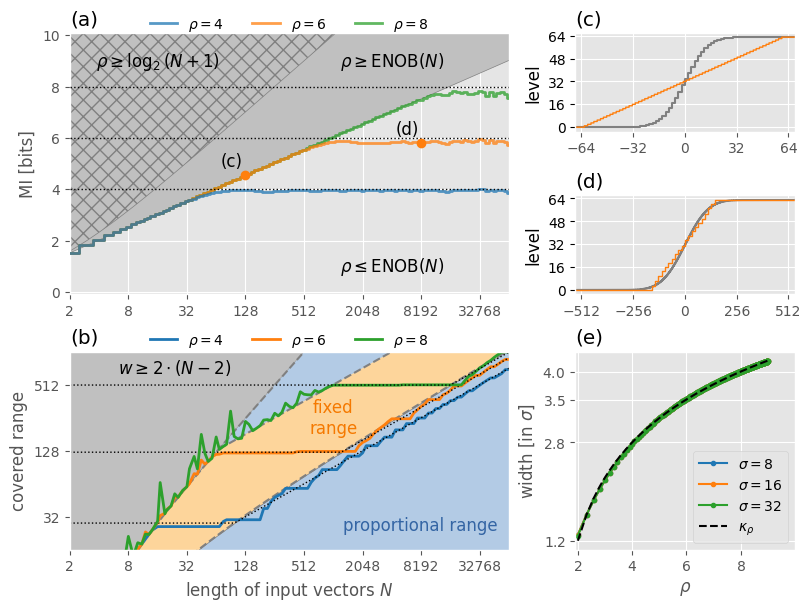

In [7]:
normalize_by_sigma = False

scale = 1 / jnp.sqrt(vector_length) if normalize_by_sigma else 1

fig, ax = plt.subplot_mosaic([["MI", "quant1"], ["MI", "quant2"], ["range", "rel"]], figsize=(8, 6), width_ratios=[1.0, 0.5], height_ratios=[0.5, 0.5, 1.0], layout="constrained")

ax["range"].sharex(ax["MI"])

ymin, ymax = -0.1, 10.1
xmin, xmax = vector_length[0], vector_length[-1]

# hatch the unachievable region > ENOB
ax["MI"].fill_between(
    vector_length,
    ymax,
    enobs,
    edgecolor="gray",
    facecolor="silver",
)

# hatch the completely unachievable region
ax["MI"].fill_between(
    vector_length,
    jnp.log2(vector_length + 1),
    jnp.zeros_like(vector_length) + ymax,
    edgecolor="gray",
    facecolor="silver",
    hatch="XX",
)

# hatch the irrelevant region for the range
p = ax["range"].fill_betweenx(
    2 * (vector_length - 2) * scale,
    vector_length,
    1,
    facecolor="silver",
    edgecolor="gray",
)

# fill the two different domains of interest
rho = jnp.linspace(1, 10, 100)
y_kinks = 2 * (2**rho - 2)
x_kinks = (y_kinks / w_opt(2**rho)) ** 2
ax["range"].patch.set_facecolor("#fdd59bff")
ax["range"].plot(
    x_kinks,
    y_kinks * (1 / jnp.sqrt(x_kinks + 2) if normalize_by_sigma else 1),
    "--",
    color="gray",
)
ax["range"].fill_betweenx(
    y_kinks * (1 / jnp.sqrt(x_kinks + 2) if normalize_by_sigma else 1),
    x_kinks,
    xmax,
    facecolor="#b3cbe5ff",
    edgecolor="gray",
    # label="fixed spacing",
)

ax["range"].plot(vector_length, 2 * (vector_length - 2) * scale, "--", color="gray")

slope = 16
# fill the region where ADC resolution is multiple sigmas and grows proportionally to sigma
idx = jnp.searchsorted(2 * (vector_length - 2) >= slope*jnp.sqrt(vector_length), True)
ax["range"].plot(vector_length[idx:], slope*jnp.sqrt(vector_length[idx:]) * scale, "--", color="gray")
ax["range"].fill_between(vector_length[idx:], slope*jnp.sqrt(vector_length[idx:]) * scale, 2 * (vector_length[idx:] - 2) * scale, facecolor="#b3cbe5ff")

ax["range"].grid(False)


# plot the individual results for each case
for i, (label1, rho) in enumerate(cases):
    # plot the limit and measured MI
    ax["MI"].step(
        vector_length,
        max_MIs[i],
        label=f"{label1}",
        where="mid",
        color=f"C{i}",
        alpha=0.75,
        lw=2,
        zorder=10-i
    )

    ax["MI"].step(
        vector_length,
        num_bits[i],
        linestyle="dotted",
        # dashes = [3,2],
        where="mid",
        color="black",
        lw=1,
        zorder=10-i
    )

    # plot the covered range of the central bins
    ax["range"].loglog(vector_length, jnp.array(max_ranges[i]) * scale, label=label1, lw=2)

    # plot the asymptote
    x_start = 2**rho - 2
    y_start = 2 * (2**rho - 2)
    x_kink = (y_start / w_opt(2**rho)) ** 2
    idx = jnp.searchsorted(vector_length, x_kink)
    x_before = vector_length[:idx]
    x_after = vector_length[idx:]
    y_before = jnp.ones_like(x_before) * y_start
    y_after = jnp.sqrt(x_after) * w_opt(2**rho)
    ax["range"].plot(
        jnp.concat([x_before, x_after]),
        jnp.concat([y_before, y_after]) * scale,
        linestyle="dotted",
        color="black",
        lw=1,
    )


# draw the quantization levels at one value
example_rho = 1
for i,(l,t, example_size) in enumerate(zip(["quant1", "quant2"],["(c)","(d)"],[128, 8192])):
    d = dists.Binomial(example_size, 0.5)
    support = jnp.array(d.enumerate_support())*2 - example_size
    probabilities = jnp.exp(d.log_prob(d.enumerate_support()))
    dd = EmpiricalDistribution(support, probabilities)

    idx = jnp.searchsorted(vector_length, example_size)
    thresh = compute_even_levels(2**rhos[example_rho], max_scales[example_rho,idx], max_phases[example_rho, idx], 
                                offset_fixed= (support[0] + support[-1]) / 2).squeeze()
    
    step = 2**int(jnp.log2(jnp.sqrt(example_size) * 4))
    aaa, lines = plot_quantization(
        ax[l],
        thresh,
        dist=dd,
        linecolor=f"C{example_rho}",
        yticklocator=MultipleLocator(16),
        xticklocator=MultipleLocator(step),
        twinaxis=False,
    )

    aaa.set_xlim(-6*jnp.sqrt(example_size), 6*jnp.sqrt(example_size))

    # plot the marker
    ax["MI"].plot([example_size], [max_MIs[example_rho, idx]], "o", color=f"C{example_rho}", zorder=10-i)
    # annotate the marker
    ax["MI"].annotate(
        t,
        (example_size, max_MIs[example_rho, idx]),
        textcoords="offset points",
        xytext=(-10, 10),
        ha="center",
        va="center",
        fontsize=12,
        # color=f"C{example_rho}",
    )

# plot the relation between vector length and optimal central region width in sigma
ax["rel"].plot(rho_sweep, data, ".-", label=[f"$\\sigma={s}$" for s in sigmas])
ax["rel"].plot(rho_sweep, w_opt(num_levels), "k--", label="$\\kappa_\\rho$")

ax["rel"].set_xlim(rho_sweep.min()-0.1, rho_sweep.max()+1)
ax["rel"].legend(loc="lower right")   

ax["MI"].set_xscale("log")
ax["MI"].set_ylabel("MI [bits]")
ax["MI"].set_ylim(ymin, ymax)
ax["MI"].set_xlim(xmin, xmax)

ax["range"].set_xlabel("length of input vectors $N$")
ax["range"].set_ylabel("covered range")



# set integer locators for each plot
ax["MI"].yaxis.set_major_locator(MaxNLocator(5, integer=True))
ax["range"].yaxis.set_major_locator(MaxNLocator(5, integer=True))

ax["MI"].set_title("(a)", loc="left")
ax["range"].set_title("(b)", loc="left")
ax["quant1"].set_title("(c)", loc="left")
ax["quant2"].set_title("(d)", loc="left")
ax["rel"].set_title("(e)", loc="left")

ax["MI"].legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 0.95),
    fancybox=False,
    facecolor="none",
    edgecolor="none",
    ncol=4,
)
ax["range"].legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 0.95),
    fancybox=False,
    facecolor="none",
    edgecolor="none",
    ncol=4,
)

if normalize_by_sigma:
    ax["range"].set_ylim(1, 32)

    xy0 = (24, 6)
    xy1 = (1024, 6)
    xy2 = (8000, 2)
else:
    ax["range"].set_ylim(16, 1024)
    xy0 = (24, 600)
    xy1 = (1024, 256)
    xy2 = (8000, 32)

ax["MI"].annotate(
    "$\\rho \\geq \\log_2(N+1)$",
    xy=(16, 9),
    ha="center",
    va="center",
    fontsize=12,
    color="black",
)
ax["MI"].annotate(
    "$\\rho \\geq \\text{ENOB}(N)$",
    xy=(4096, 9),
    ha="center",
    va="center",
    fontsize=12,
    color="black",
)
ax["MI"].annotate(
    "$\\rho \\leq \\text{ENOB}(N)$",
    xy=(4096, 1),
    ha="center",
    va="center",
    fontsize=12,
    color="black",
)

ax["range"].annotate(
    "$w \\geq 2\\cdot(N-2)$", xy=xy0, ha="center", va="bottom", fontsize=12, color="black"
)
ax["range"].annotate(
    "fixed\nrange", xy=xy1, ha="center", va="center", fontsize=12, color="#f57900ff"
)
ax["range"].annotate(
    "proportional range", xy=xy2, ha="center", va="top", fontsize=12, color="#3465a4ff"
)

power_of_2_scaling = (jnp.log2, lambda x: 2**x)
ax["range"].set_xscale("function", functions=power_of_2_scaling)
ax["range"].set_yscale("function", functions=power_of_2_scaling)
ax["range"].xaxis.set_major_locator(FixedLocator([2**i for i in range(1, 16, 2)]))
ax["range"].yaxis.set_major_locator(FixedLocator([2**i for i in range(1, 11, 2)]))
ax["MI"].yaxis.set_major_locator(MultipleLocator(2))

xtest = jnp.array([2, 4,6,8])
ytest = w_opt(2**xtest)
ax["rel"].set_xticks(xtest)
ax["rel"].set_yticks(ytest)
ax["rel"].set_xlabel("$\\rho$")
ax["rel"].set_ylabel("width [in $\\sigma$]")

# set formatter
ax["rel"].xaxis.set_major_formatter("${x}$")
ax["rel"].yaxis.set_major_formatter("${x:.1f}$")
# hide minor ticks
ax["rel"].xaxis.set_minor_locator(plt.NullLocator())

In [8]:

fig.savefig("../figures/range.pdf", bbox_inches="tight", dpi=300)
fig.savefig("../figures/range.svg", bbox_inches="tight", dpi=300)
fig.savefig("../figures/range.png", bbox_inches="tight", dpi=300)


# continuous limit:
# entropy of sliced Gaussian

\begin{align}
H(Y) &= \sum_y p_Y(y) \log p_Y(y) \\ 
&= \sum_y (F_Y(\theta_{y+1}) - F_Y(\theta_{y})) \log (F_Y(\theta_{y+1}) - F_Y(\theta_{y})) \\ 
&= \sum_y (F_Y(\alpha (y+1)) - F_Y(\alpha y)) \log (F_Y(\alpha (y+1)) - F_Y(\alpha y)) \\ 
\frac{dH(Y)}{d\alpha} &= \sum_y \frac{d}{d\alpha}(F_Y(\alpha (y+1)) - F_Y(\alpha y)) \log (F_Y(\alpha (y+1)) - F_Y(\alpha y)) \\ 
&\quad + (F_Y(\alpha (y+1)) - F_Y(\alpha y)) \frac{d}{d\alpha}\log (F_Y(\alpha (y+1)) - F_Y(\alpha y)) \nonumber\\
 &= \sum_y \frac{d}{d\alpha}(F_Y(\alpha (y+1)) - F_Y(\alpha y)) (1+\log (F_Y(\alpha (y+1)) - F_Y(\alpha y))) \\ 
 &= \sum_y (p_Y(\alpha (y+1))(y+1) - p_Y(\alpha y)y) (1+\log (F_Y(\alpha (y+1)) - F_Y(\alpha y))) \\ 
\end{align}

In [22]:
# relevant values for the paper
w_opt(2**jnp.array([4,5,6]))

Array([2.82247199, 3.21433549, 3.51495091], dtype=float64)